# Extracting Data from Excel and Loading into Databases  `(2 DB)`


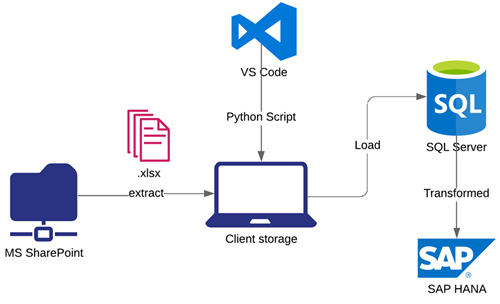

## Process Overview:
### Excel ~-> SQL Server ~-> SAP HANA
1. **Extract Data from Excel:** Retrieve data from an Excel (.xlsx) file.
2. **Convert to Pandas DataFrame:** Read data from any sheet in the Excel file and create a Pandas DataFrame.
3. **Load into SQL Server:** Insert the data into a SQL Server database.
4. **Data Transformation:** Perform transformations such as unpivoting and cleansing.
5. **Transfer to SAP HANA:** Select data from SQL Server and insert it into a SAP HANA database.


Configculation

In [495]:

import pandas as pd #pip install `openpyxl`, engine for read_excel
import os
from dotenv import load_dotenv

load_dotenv()

class config:
    mssql_server =  os.getenv("mssql_server")
    mssql_db = os.getenv("mssql_db")
    mssql_user = os.getenv("mssql_user")
    mssql_pw = os.getenv("mssql_pw")
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    hana_host = os.getenv("hana_host")
    hana_port = os.getenv("hana_port")
    hana_user = os.getenv("hana_user")
    hana_pw = os.getenv("hana_pw")

#  config excel
pathFile = r'C:\Users\siravit.pim\Desktop\salesTarget/'
excelFile = 'merge.xlsx'
file_path = os.path.join(pathFile, excelFile)

columns = ['Date', 'Sales Code', 'TMZ','TMS','P-Gal2','Lip-C','Sheet','PAP Plus','MTO','FiGuard','PAP System','Conduit','ZONA','PAP']
sheetName = ['2024-1','2024-2','2024-3','2023-7','2023-8','2023-9','2023-10','2023-11','2023-12'] 
    
    

Connect to the `SQL Server`

In [496]:
import pyodbc

try:   
    conn = pyodbc.connect(f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={config.mssql_server};DATABASE={config.mssql_db};UID={config.mssql_user};PWD={config.mssql_pw}')
    cursor = conn.cursor()
    
    print("Connection established successfully!")
except Exception as e:
    print("An error occurred:", e)

Connection established successfully!


In [497]:
# create table
query = """
    DROP TABLE if exists tempSalesTarget ;
    CREATE TABLE tempSalesTarget (
       	Date            DATE,
        SalesCode       NVARCHAR(20),
        TMZ	            INT,
        TMS	            INT,
        [P-Gal]         INT,
        [Lip C]         INT,
        Sheet           INT,
        [PAP Plus]      INT,
        MTO	            INT,
        FiGuard	        INT,
        [PAP System]    INT,
        Conduit	        INT,
        ZONA            INT,	
        PAP             INT
    );
"""
cursor.execute(query)
cursor.commit()

In [500]:
# Read data from excel and insert values

for sheet in sheetName:
    df = pd.read_excel(io= file_path,
                    sheet_name= sheet,
                    usecols= columns)
    
    df.fillna(0, inplace=True)
    
    for index, row in df.iterrows():
        cursor.execute("INSERT INTO tempSalesTarget (Date, SalesCode, TMZ, TMS, [P-Gal], [Lip C] , Sheet, [PAP Plus], MTO, FiGuard, [PAP System], Conduit, ZONA, PAP) VALUES (?, ?, ?,?, ?, ?,?, ?, ?, ?, ?,?, ?, ?)",
                    row['Date'], row['Sales Code'], row['TMZ'], row['TMS'], row['P-Gal2'], row['Lip-C'], row['Sheet'], row['PAP Plus'], row['MTO'], row['FiGuard'], row['PAP System'], row['Conduit'], row['ZONA'], row['PAP'])

        cursor.commit()

df.head()

,Date,Sales Code,TMZ,TMS,P-Gal2,Lip-C,Sheet,PAP Plus,MTO,FiGuard,PAP System,Conduit,ZONA,PAP
0,2023-01-12,1400175,1100,300,200.0,50.0,100.0,0.0,0.0,50.0,0.0,0.0,0.0,500.0
1,2023-01-12,1400170,1050,400,400.0,250.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2,2023-01-12,1400180,700,500,100.0,100.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-12,1400186,1100,730,120.0,150.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-12,1400039,900,600,100.0,120.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [501]:
# cleansing data and drop temp table / create new table

## unpivot horizontal to vertical for analysis
query = """
    DROP TABLE if exists SalesTarget;
	WITH clean as (
		SELECT Date, SalesCode, [Brand], [Value]
		FROM (
			SELECT Date, SalesCode, TMZ, TMS, [P-Gal], [Lip C], Sheet, [PAP Plus], MTO, FiGuard, [PAP System], Conduit, ZONA, PAP
			FROM tempSalesTarget
		) AS SourceTable
		UNPIVOT (
			[Value] FOR [Brand] IN (TMZ, TMS, [P-Gal], [Lip C], Sheet, [PAP Plus], MTO, FiGuard, [PAP System], Conduit, ZONA, PAP)
		) AS UnpivotedData
	) select * 
	into SalesTarget
	from clean 
	where Value > 0 ;
 
 	DROP TABLE tempSalesTarget
"""
cursor.execute(query)
cursor.commit()

Fetched data from SQL Server make dataFrame, prepare for transfer data

In [502]:
query = """
    SELECT * FROM SalesTarget;
"""

rows = [tuple(row) for row in cursor.execute(query).fetchall()]
columns = [column[0] for column in cursor.description]

df_cleaned = pd.DataFrame(rows, columns= columns)

query_end = """ 
    DROP TABLE SalesTarget; 
"""

cursor.execute(query)
cursor.commit()

cursor.close()
conn.close()

df_cleaned.head()

,Date,SalesCode,Brand,Value
0,2024-01-01,1400175,TMZ,1150
1,2024-01-01,1400175,TMS,350
2,2024-01-01,1400175,P-Gal,300
3,2024-01-01,1400175,Lip C,100
4,2024-01-01,1400175,Sheet,200


Connect to the `SAP HANA`

In [489]:
from hdbcli import dbapi

try:   
    conn2 = dbapi.connect(address= f'{config.hana_host}',
                             port= f'{config.hana_port}',
                             user= f'{config.hana_user}',
                             password= f'{config.hana_pw}')
    
    conn2.commit()
    cursor2 = conn2.cursor()
    print("Connection established successfully!")
    
except Exception as e:
    print("An error occurred:", e)

Connection established successfully!


In [492]:
# DROP TABLE first
sql_hana1 = """ 
    DROP TABLE "BIITPL01"."FI.FactSalesTarget" ; 
"""
cursor2.execute(sql_hana1)

# CREATE TABLE
sql_hana2 = """ 
    CREATE TABLE "BIITPL01"."FI.FactSalesTarget"  (
       	"Date"      DATE,
        "SalesCode" NVARCHAR(20),
        "Brand"	    NVARCHAR(20),
        "Value"	    INT
    ); 
"""
cursor2.execute(sql_hana2)

True

In [493]:
# Insert data into SAP HANA
sql = 'INSERT INTO "BIITPL01"."FI.FactSalesTarget"  ("Date", "SalesCode", "Brand", "Value") VALUES (?, ?, ?, ?)'
                  
for index, row in df_cleaned.iterrows():
    cursor2.execute(sql, (row['Date'], row['SalesCode'], row['Brand'], row['Value']))

In [494]:
# Test data
sql_hana = 'SELECT * FROM "BIITPL01"."FI.FactSalesTarget" LIMIT 5;'

cursor2.execute(sql_hana)

for row in cursor2:
    print(row)
    
cursor2.close()
conn2.close()

(datetime.date(2024, 1, 1), '1400175', 'TMZ', 1150)
(datetime.date(2024, 1, 1), '1400175', 'TMS', 350)
(datetime.date(2024, 1, 1), '1400175', 'P-Gal', 300)
(datetime.date(2024, 1, 1), '1400175', 'Lip C', 100)
(datetime.date(2024, 1, 1), '1400175', 'Sheet', 200)
